In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plt_show_color(image):
    b, g, r = cv2.split(image)
    img = cv2.merge([r,g,b])
    plt.imshow(img)
    plt.show()

In [3]:
def plt_show_gray(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [64]:
def color_position(image):
    colors = [
        # ([26, 43, 46], [34, 255, 255]),  # 黄色
#         ([100, 43, 46], [124, 255, 255]),  # 蓝色
        ([100, 100, 50], [124, 255, 255])
        # ([35, 43, 46], [77, 255, 255])   # 绿色
    ]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    for (lower, upper) in colors:
        lower = np.array(lower, dtype="uint8")  # 颜色下限
        upper = np.array(upper, dtype="uint8")  # 颜色上限

        # 根据阈值找到相应的颜色
        mask = cv2.inRange(hsv, lowerb=lower, upperb=upper)
        output = cv2.bitwise_and(image, image, mask=mask)
        # cv2.imshow("image", img)
        # cv2.imshow("image_color", output)
        # cv2.waitKey(0)
    return output

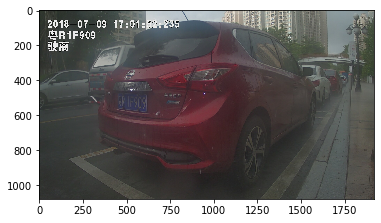

In [96]:
# 图像显示
src = cv2.imread(r'D:/Pycharm_Project/Vehicle_license_plate_recognition/cardsneed/20180709/153112698065.jpg')
plt_show_color(src)

In [97]:
sp = src.shape
print(sp[0])
print(sp[1])

1080
1920


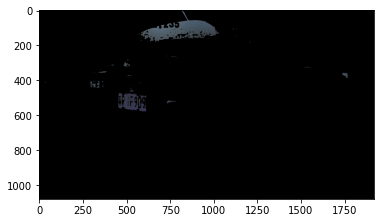

In [98]:
# 首先颜色过滤掉白色的字，然后进行高斯模糊
src2 = src.copy()
# src2 = src2[int(sp[0]/10):int(sp[0]*4/5):, :int(sp[1]*2/5)]
src2 = color_position(src2)
Gauss = cv2.GaussianBlur(src2, (11, 11), 0)
plt_show_color(Gauss)

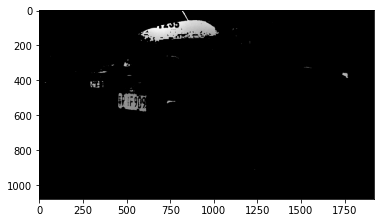

In [99]:
# 转换为灰度图
gray = cv2.cvtColor(Gauss, cv2.COLOR_BGR2GRAY)
plt_show_gray(gray)

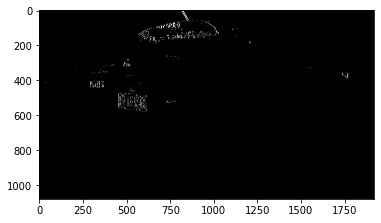

In [100]:
# sobel算子边缘检测
Sobel_x = cv2.Sobel(gray, cv2.CV_16S, 1, 0)
absX = cv2.convertScaleAbs(Sobel_x)
image = absX.copy()
plt_show_gray(image)
# cv2.imshow("sobel", image)

In [101]:
# 闭运算，讲白色部分连成整体
# kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 5))
# # print(kernelX)
# image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernelX, iterations=4)
# plt_show_gray(image)
# cv2.imshow("close", image)

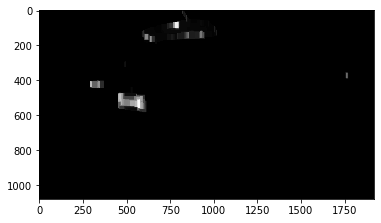

In [102]:
# 去除小的白点来创建的
kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (31, 1))
kernelY = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 31))
# 膨胀，腐蚀
image = cv2.dilate(image, kernelX)
image = cv2.erode(image, kernelX)
# 腐蚀，膨胀
image = cv2.erode(image, kernelY)
image = cv2.dilate(image, kernelY)
plt_show_gray(image)

In [103]:
# # 中值滤波去除噪点
# image = cv2.medianBlur(image, 15)
# plt_show_gray(image)

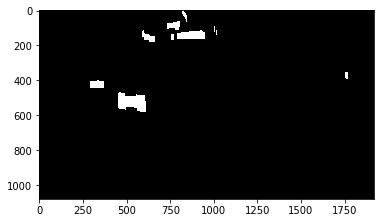

In [104]:
# 转化为二值图象，以用于findcontours
ret, binary = cv2.threshold(image, 5, 255, cv2.THRESH_BINARY)
plt_show_gray(binary)

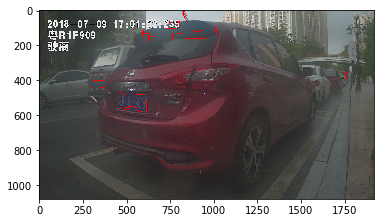

In [105]:
# 轮廓检测
# cv2.RETR_EXTERNAL表示只检测外轮廓
# cv2.CHAIN_APPROX_SIMPLE压缩水平方向，垂直方向，对角线方向的元素， 只保留该方向的终点坐标，
# 例如一个矩形轮廓只需要四个点来保存轮廓信息
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 绘制轮廓
imagel = src.copy()
cv2.drawContours(imagel, contours, -1, (0, 0, 255), 2)
plt_show_color(imagel)

In [106]:
def unevenLightCompensate(img, blockSize):# 光照均衡化，过度地带颜色偏深
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    average = np.mean(gray)

    rows_new = int(np.ceil(gray.shape[0] / blockSize))
    cols_new = int(np.ceil(gray.shape[1] / blockSize))

    blockImage = np.zeros((rows_new, cols_new), dtype=np.float32)
    for r in range(rows_new):
        for c in range(cols_new):
            rowmin = r * blockSize
            rowmax = (r + 1) * blockSize
            if (rowmax > gray.shape[0]):
                rowmax = gray.shape[0]
            colmin = c * blockSize
            colmax = (c + 1) * blockSize
            if (colmax > gray.shape[1]):
                colmax = gray.shape[1]

            imageROI = gray[rowmin:rowmax, colmin:colmax]
            temaver = np.mean(imageROI)
            blockImage[r, c] = temaver

    blockImage = blockImage - average
    blockImage2 = cv2.resize(blockImage, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_CUBIC)
    gray2 = gray.astype(np.float32)
    dst = gray2 - blockImage2
    dst = dst.astype(np.uint8)
    dst = cv2.GaussianBlur(dst, (3, 3), 0)

    return dst

In [107]:
def way2(image):
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    yuv[..., 0] = cv2.equalizeHist(yuv[..., 0])
    equalized_color = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
    return equalized_color

452 471 164 113


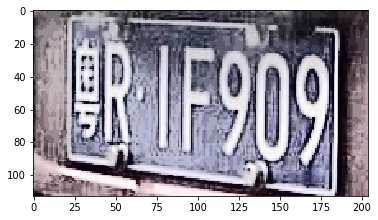

292 401 80 46


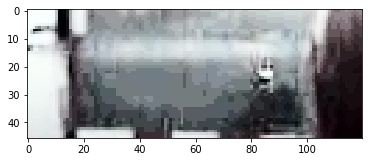

790 116 161 51


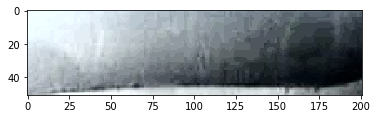

734 62 72 53


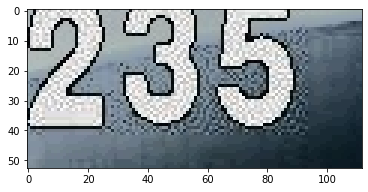

In [108]:
image_all = []
blockSize = 16
i = 0
for item in contours:
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    weight = rect[2]
    height = rect[3]  
    if (weight > (height*1.2)) and (weight < (height*6)):
        if y-10<0 or x - 20<0 or y + height + 10>imagel.shape[0] or x + weight+20>imagel.shape[1]:
            image = src[y:y + height, x:x+weight]
        else:
            print(x,y,weight,height)
            image = src[y :y + height, x - 20:x + weight+20]
        i = i+1
#         image = unevenLightCompensate(image, blockSize)
        image_all.append(image)
#         plt_show_gray(image)
        image = way2(image)
        plt_show_color(image)
        cv2.imwrite("wor"+str(i)+".jpg", image)
        